In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Wavmat import Wavmat 
from scipy import signal

In [11]:
data = np.loadtxt('G95071505.txt')

df = pd.DataFrame(data[0:2048, ], columns=['col1', 'col2', 'col3', 'col4', 'col5'])

# variables of interest are columns 3 and 4
var1 = df['col3'] # vertical velocity
var2 = df['col4'] # turbulence

# data sampled at 56Hz at intervals of 19.5 minutes
df.head()

,col1,col2,col3,col4,col5
0,3.6021,-0.9198,0.2016,304.0597,23.5969
1,3.5201,-0.8218,0.1936,304.0669,24.7804
2,3.5146,-0.8085,0.3009,304.0669,24.9667
3,3.6330,-0.7293,0.4826,304.1164,26.5712
4,3.5085,-0.6815,0.3684,304.0748,26.9290


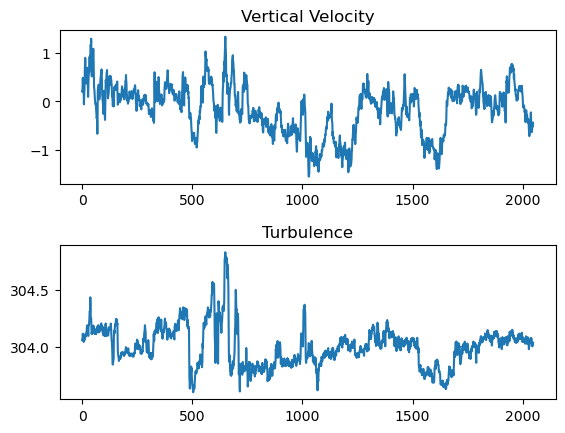

In [12]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
plt.plot(var1)
plt.title('Vertical Velocity')

plt.subplot(2,1,2)
plt.plot(var2)
plt.title('Turbulence')

plt.savefig('atm.png')

In [13]:
N = 2048

#these need to be Nx1
var1 = np.transpose(np.matrix(var1))
var2 = np.transpose(np.matrix(var2))

#use default Haar wavelet
W = Wavmat(N, None, 6) 

#WT of data by 'hfilt' @ 6 levels of detail
wd_v1 = W * var1
wd_v2 = W * var2

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


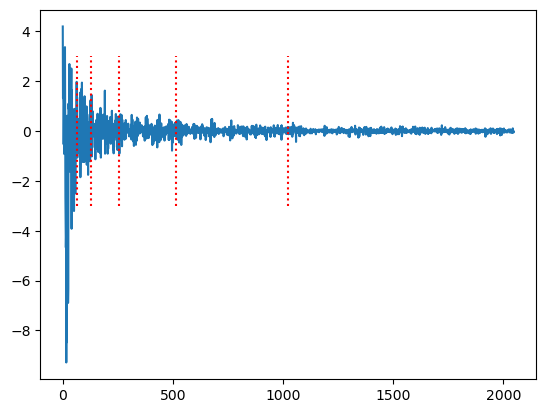

In [14]:
# column 3
decomps = [1024, 512, 256, 128, 64]

plt.plot(wd_v1)
for i in decomps:
    plt.vlines(x=i, ymin=-3, ymax=3, colors='red', ls=':')

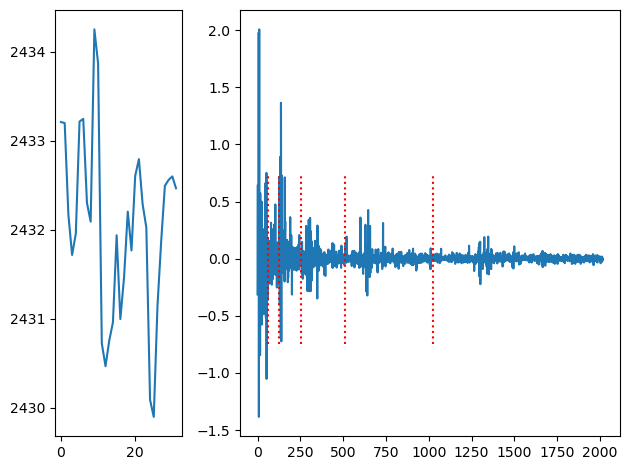

In [15]:
#column 4
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
a0.plot(wd_v2[0:32])

a1.plot(wd_v2[32:2048])
for i in decomps:
    a1.vlines(x=i, ymin=-0.75, ymax=0.75, colors='red', ls=':')

f.tight_layout()

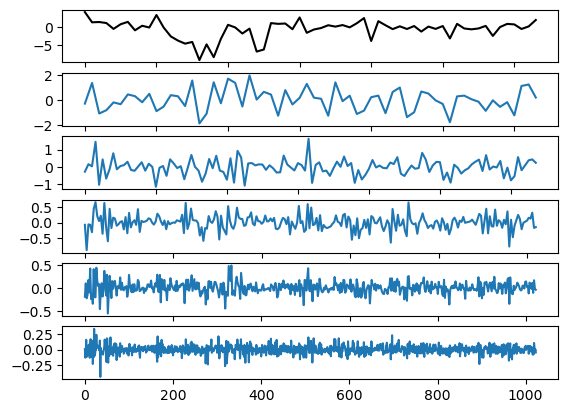

In [7]:
fig, axs = plt.subplots(6, 1)
axs[0].plot(wd_v1[0:64], color='k')
axs[1].plot(wd_v1[64:128])
axs[2].plot(wd_v1[128:256])
axs[3].plot(wd_v1[256:512])
axs[4].plot(wd_v1[512:1024])
axs[5].plot(wd_v1[1024:2048])

In [16]:
from scipy.stats import pearsonr, norm

In [17]:
dyadic = [32, 64, 128, 256, 512, 1024, 2048]

v1_decomps = {}
for i in range(len(dyadic)-1):
    v1_decomps[f'v1_l{i+1}'] = np.squeeze(np.array(wd_v1[dyadic[i]:dyadic[i+1]]))

v2_decomps = {}
for i in range(len(dyadic)-1):
    v2_decomps[f'v2_l{i+1}'] = np.squeeze(np.array(wd_v2[dyadic[i]:dyadic[i+1]]))
    
v1list = list(v1_decomps.keys())
v2list = list(v2_decomps.keys())

In [18]:
# wavelet-decomposition level correlations:
corrs = []
for i in range(len(v1list)):
    corrs.append(pearsonr(v1_decomps[v1list[i]], v2_decomps[v2list[i]])[0])

corrs

[0.4506244328282417,
 0.3773117432042983,
 0.393841895677694,
 0.16542086080027846,
 0.3520693460499351,
 0.12532125673863106]

In [19]:
# for comparison:

#var2.shape both are (2048,1)

stats.pearsonr(np.squeeze(np.array(var1)), np.squeeze(np.array(var2)))[0]

NameError: name 'stats' is not defined

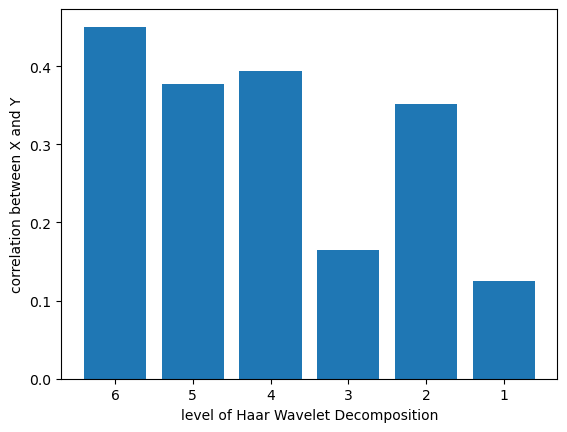

In [20]:
# plot correlation coefficients based on WD level
plt.figure()
plt.bar(range(1,7), corrs)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between X and Y')
plt.xticks(range(1,7), [6,5,4,3,2,1])
plt.show()

In [21]:
# confidence intervals
def CI(n,r,a):
    w = 0.5*np.log((1+r)/(1-r))
    z = norm.ppf(1-(a/2))
    wL = w-(z/np.sqrt(n-3))
    wU = w+(z/np.sqrt(n-3))
    rCI = np.zeros(2)
    rCI[0] = (np.exp(2*wL)-1)/(np.exp(2*wL)+1)
    rCI[1] = (np.exp(2*wU)-1)/(np.exp(2*wU)+1)
    return rCI

# call CI for all levels
CIs = np.empty((6,2))
for i in range(6):
    CIs[i] = CI(dyadic[i],corrs[i],0.05)
    
CIs

array([[0.12093261, 0.69077665],
       [0.1449457 , 0.57023371],
       [0.23647278, 0.53107672],
       [0.04370525, 0.2822976 ],
       [0.27376565, 0.42573657],
       [0.06455489, 0.18516167]])

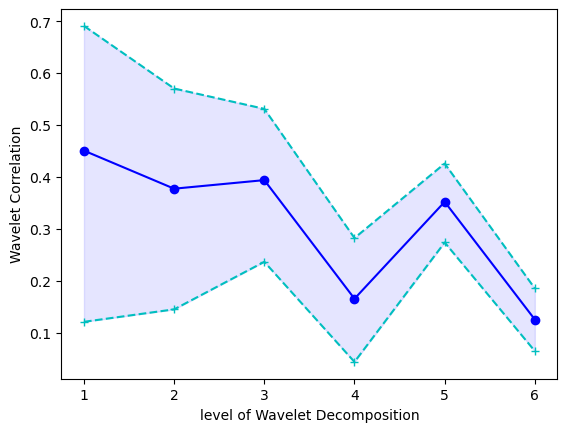

In [22]:
# confidence intervals 
lows = CIs[:, 0]
highs = CIs[:, 1]

fig, ax = plt.subplots()
ax.plot(range(1,7), corrs, 'bo-')
ax.plot(range(1,7), lows, 'c+--')
ax.plot(range(1,7), highs, 'c+--')
ax.fill_between(range(1,7), lows, highs, color='b', alpha=.1)
ax.set_xlabel('level of Wavelet Decomposition')
ax.set_ylabel('Wavelet Correlation')

plt.savefig('atm_WCC.png')

In [ ]:
# Extra: lagged cross correlation
# would be easier to do this if there was more information about the data (specifically, periodicity of data collection)

